# Quantum-Aegis: Experimental Demonstration

This notebook contains the experimental demonstration of the Quantum-Aegis project, including:

1. **Convergence Plots**: Energy vs. Iteration count for VQE and QAOA
2. **Scaling Graphs**: Computation time vs. Problem Size (N) for both Quantum and Classical approaches
3. **Noise Analysis**: Success probability rates under varying error rates

## Project Overview

This project investigates the application of Variational Quantum Algorithms (VQE and QAOA) to solve combinatorial optimization problems found in competitive gaming environments. Focusing on the "Tactical Position Selection" problem, we map the scenario to a Quadratic Unconstrained Binary Optimization (QUBO) model.


In [4]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import List, Dict, Any

# Add parent directory to path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import project modules
from quantum_aegis.problem.tactical import TacticalPositionProblem
from quantum_aegis.solvers.quantum.vqe import VQESolver
from quantum_aegis.solvers.quantum.qaoa import QAOASolver
from quantum_aegis.solvers.classical.brute_force import BruteForceSolver
from quantum_aegis.solvers.classical.greedy import GreedySolver
from quantum_aegis.noise.models import create_combined_noise_model
from quantum_aegis.utils.visualization import plot_convergence, plot_scaling, plot_noise_analysis
from qiskit_algorithms.optimizers import SPSA, COBYLA

print("All imports successful!")


All imports successful!


## Phase I: Algorithmic Implementation

### 1. Convergence Analysis: VQE vs QAOA

We compare the convergence properties of VQE and QAOA on a small problem instance (N=4).


In [5]:
# Create a problem instance
N = 4
problem = TacticalPositionProblem(N=N, seed=42)
qubo = problem.get_qubo()

# Get optimal solution for reference
optimal_x, optimal_energy = problem.get_optimal_solution()
print(f"Optimal solution: {optimal_x}")
print(f"Optimal energy: {optimal_energy:.4f}")
print(f"Selected position: {np.argmax(optimal_x)}")


Optimal solution: [1 0 0 0]
Optimal energy: 0.7983
Selected position: 0


In [3]:
# Run VQE
print("Running VQE...")
vqe_solver = VQESolver(optimizer=SPSA(maxiter=100), ansatz_reps=2, seed=42)
vqe_result = vqe_solver.solve(qubo)

print(f"VQE solution: {vqe_result['bitstring']}")
print(f"VQE energy: {vqe_result['energy']:.4f}")
print(f"VQE selected position: {np.argmax(vqe_result['bitstring'])}")
print(f"VQE iterations: {len(vqe_result['optimization_history'])}")


Running VQE...
VQE solution: [1 0 0 0]
VQE energy: -20.5112
VQE selected position: 0
VQE iterations: 251


In [6]:
# Run QAOA
print("Running QAOA...")
qaoa_solver = QAOASolver(optimizer=SPSA(maxiter=100), reps=2, seed=42)
qaoa_result = qaoa_solver.solve(qubo)

print(f"QAOA solution: {qaoa_result['bitstring']}")
print(f"QAOA energy: {qaoa_result['energy']:.4f}")
print(f"QAOA selected position: {np.argmax(qaoa_result['bitstring'])}")
print(f"QAOA iterations: {len(qaoa_result['optimization_history'])}")


Running QAOA...


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

QAOA solution: [1 0 0 0]
QAOA energy: -6.3294
QAOA selected position: 0
QAOA iterations: 251


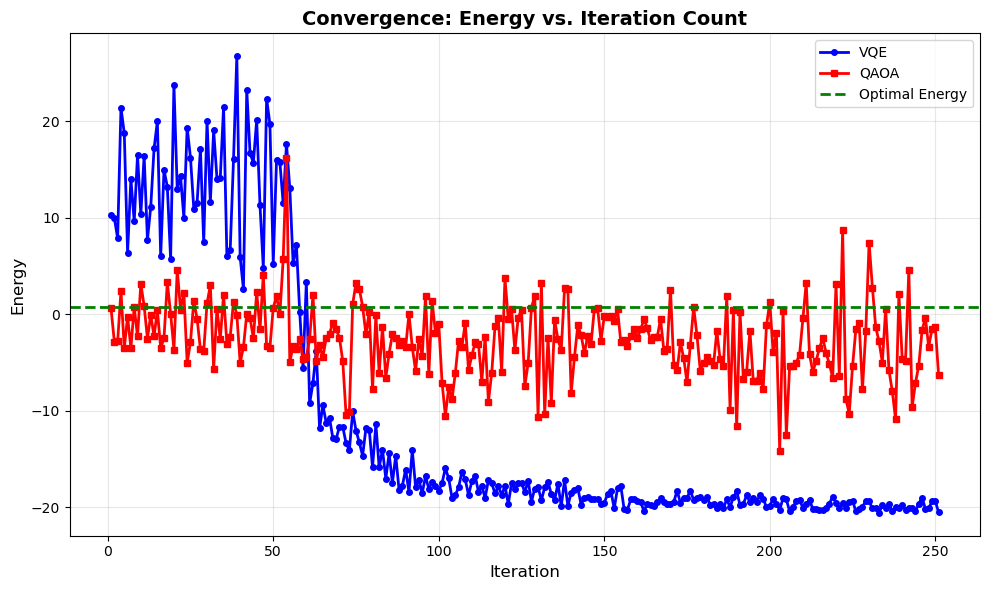

In [7]:
# Plot convergence
plot_convergence(
    vqe_history=vqe_result['optimization_history'],
    qaoa_history=qaoa_result['optimization_history'],
    optimal_energy=optimal_energy,
    save_path='../results/convergence_plot.png'
)


## Phase II: Noise Resilience & Tuning

### 2. Optimizer Comparison: SPSA vs COBYLA

We compare the performance of SPSA and COBYLA optimizers under noisy conditions.


Testing VQE with SPSA optimizer (noisy)...
SPSA VQE energy: -20.8889
Testing VQE with COBYLA optimizer (noisy)...
COBYLA VQE energy: -21.2662


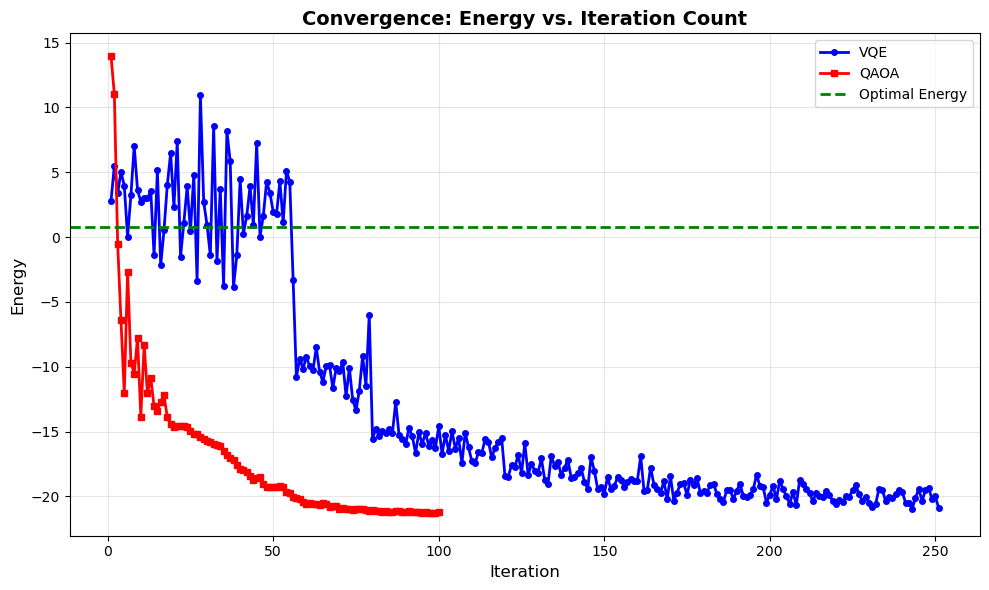

In [8]:
# Create noise model
gate_error = 0.01
readout_error = 0.01
noise_model = create_combined_noise_model(gate_error=gate_error, readout_error=readout_error)

# Test with SPSA
print("Testing VQE with SPSA optimizer (noisy)...")
vqe_spsa = VQESolver(optimizer=SPSA(maxiter=100), ansatz_reps=2, use_noise=True, noise_model=noise_model, seed=42)
vqe_spsa_result = vqe_spsa.solve(qubo)
print(f"SPSA VQE energy: {vqe_spsa_result['energy']:.4f}")

# Test with COBYLA
print("Testing VQE with COBYLA optimizer (noisy)...")
vqe_cobyla = VQESolver(optimizer=COBYLA(maxiter=100), ansatz_reps=2, use_noise=True, noise_model=noise_model, seed=42)
vqe_cobyla_result = vqe_cobyla.solve(qubo)
print(f"COBYLA VQE energy: {vqe_cobyla_result['energy']:.4f}")

# Compare convergence
plot_convergence(
    vqe_history=vqe_spsa_result['optimization_history'],
    qaoa_history=vqe_cobyla_result['optimization_history'],
    optimal_energy=optimal_energy,
    save_path='../results/optimizer_comparison.png'
)
# 下面画的图不太对，图上比较的是QAOA和VQE，代码中是vqe_cobyla赋值给了qaoa


### 3. Noise Analysis: Success Probability vs. Error Rate

We analyze how success probability changes with varying error rates.



Testing error rate: 0.0


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  VQE success: True, Energy: -21.5069
  QAOA success: False, Energy: -2.9392

Testing error rate: 0.001


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  VQE success: True, Energy: -21.4528
  QAOA success: True, Energy: -7.5581

Testing error rate: 0.005


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  VQE success: True, Energy: -16.9477
  QAOA success: True, Energy: -4.3997

Testing error rate: 0.01


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  VQE success: True, Energy: -20.5717
  QAOA success: True, Energy: 0.4777

Testing error rate: 0.02


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  VQE success: True, Energy: -21.4413
  QAOA success: True, Energy: -6.3259

Testing error rate: 0.05


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  VQE success: True, Energy: -20.0654
  QAOA success: True, Energy: -6.1210


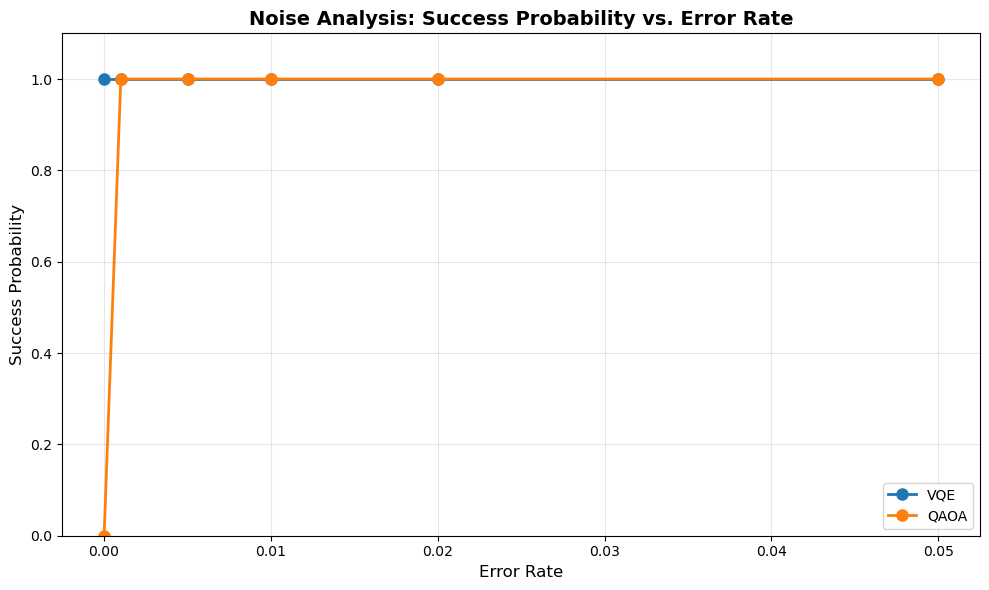

In [13]:
# Define error rates to test
error_rates = [0.0, 0.001, 0.005, 0.01, 0.02, 0.05]
success_rates_vqe = []
success_rates_qaoa = []

# Run experiments for each error rate
for error_rate in error_rates:
    print(f"\nTesting error rate: {error_rate}")
    
    # Create noise model
    noise_model = create_combined_noise_model(gate_error=error_rate, readout_error=error_rate)
    
    # Test VQE
    vqe_noisy = VQESolver(optimizer=SPSA(maxiter=50), ansatz_reps=2, use_noise=(error_rate > 0), 
                          noise_model=noise_model if error_rate > 0 else None, seed=42)
    vqe_result_noisy = vqe_noisy.solve(qubo)
    
    # Test QAOA
    qaoa_noisy = QAOASolver(optimizer=SPSA(maxiter=50), reps=2, use_noise=(error_rate > 0),
                            noise_model=noise_model if error_rate > 0 else None, seed=42)
    qaoa_result_noisy = qaoa_noisy.solve(qubo)
    
    # Check if solution matches optimal (within tolerance)
    vqe_success = np.allclose(vqe_result_noisy['bitstring'], optimal_x) or \
                  (np.abs(vqe_result_noisy['energy'] - optimal_energy) < 0.1)
    qaoa_success = np.allclose(qaoa_result_noisy['bitstring'], optimal_x) or \
                   (np.abs(qaoa_result_noisy['energy'] - optimal_energy) < 0.1)
    
    success_rates_vqe.append(1.0 if vqe_success else 0.0)
    success_rates_qaoa.append(1.0 if qaoa_success else 0.0)
    
    print(f"  VQE success: {vqe_success}, Energy: {vqe_result_noisy['energy']:.4f}")
    print(f"  QAOA success: {qaoa_success}, Energy: {qaoa_result_noisy['energy']:.4f}")

# Plot noise analysis
plot_noise_analysis(
    error_rates=error_rates,
    success_rates={'VQE': success_rates_vqe, 'QAOA': success_rates_qaoa},
    save_path='../results/noise_analysis.png'
)


## Phase III: Scaling Analysis (Quantum vs. Classical)

### 4. Computation Time vs. Problem Size

We benchmark "Time to Solution" and "Solution Quality" across varying problem sizes: N ∈ {4, 8, 12, 16}.


In [ ]:
# Problem sizes to test
problem_sizes = [4, 8, 12]
quantum_times = {'VQE': [], 'QAOA': []}
classical_times = {'brute_force': [], 'greedy': []}

# Run scaling experiments
for N in problem_sizes:
    print(f"\n{'='*50}")
    print(f"Testing problem size N = {N}")
    print(f"{'='*50}")
    
    # Create problem
    problem = TacticalPositionProblem(N=N, seed=42)
    qubo = problem.get_qubo()
    
    # Classical: Brute Force (only for small N)
    if N <= 12:
        print("Running Brute Force...")
        brute_solver = BruteForceSolver()
        brute_result = brute_solver.solve(qubo)
        classical_times['brute_force'].append(brute_result['elapsed_time'])
        print(f"  Brute Force time: {brute_result['elapsed_time']:.4f}s, Energy: {brute_result['energy']:.4f}")
    else:
        classical_times['brute_force'].append(np.nan)
    
    # Classical: Greedy
    print("Running Greedy...")
    greedy_solver = GreedySolver()
    greedy_result = greedy_solver.solve(qubo)
    classical_times['greedy'].append(greedy_result['elapsed_time'])
    print(f"  Greedy time: {greedy_result['elapsed_time']:.4f}s, Energy: {greedy_result['energy']:.4f}")
    
    # Quantum: VQE
    print("Running VQE...")
    vqe_solver = VQESolver(optimizer=SPSA(maxiter=50), ansatz_reps=2, seed=42)
    start_time = time.time()
    vqe_result = vqe_solver.solve(qubo)
    vqe_time = time.time() - start_time
    quantum_times['VQE'].append(vqe_time)
    print(f"  VQE time: {vqe_time:.4f}s, Energy: {vqe_result['energy']:.4f}")
    
    # Quantum: QAOA
    print("Running QAOA...")
    qaoa_solver = QAOASolver(optimizer=SPSA(maxiter=50), reps=2, seed=42)
    start_time = time.time()
    qaoa_result = qaoa_solver.solve(qubo)
    qaoa_time = time.time() - start_time
    quantum_times['QAOA'].append(qaoa_time)
    print(f"  QAOA time: {qaoa_time:.4f}s, Energy: {qaoa_result['energy']:.4f}")

print("\nScaling experiments completed!")



Testing problem size N = 4
Running Greedy...
  Greedy time: 0.0001s, Energy: 0.7983
Running VQE...
  VQE time: 0.1305s, Energy: -13.0996
Running QAOA...


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  QAOA time: 3.8660s, Energy: -0.2698

Testing problem size N = 8
Running Greedy...
  Greedy time: 0.0000s, Energy: 0.6458
Running VQE...
  VQE time: 0.2390s, Energy: -104.8638
Running QAOA...


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more effic

  QAOA time: 150.2849s, Energy: 1.1606

Testing problem size N = 12
Running Greedy...
  Greedy time: 0.0001s, Energy: 0.5412
Running VQE...
  VQE time: 0.8793s, Energy: -224.1969
Running QAOA...


/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/opt/anaconda3/envs/sixtyMinutes/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


KeyboardInterrupt: 

In [ ]:
# Plot scaling analysis
plot_scaling(
    problem_sizes=problem_sizes,
    quantum_times=quantum_times,
    classical_times=classical_times,
    save_path='../results/scaling_analysis.png'
)


## Summary

This experimental demonstration has shown:

1. **Convergence Analysis**: Both VQE and QAOA converge to near-optimal solutions, with different convergence characteristics.

2. **Noise Resilience**: The algorithms show varying degrees of robustness to noise, with success probability decreasing as error rates increase.

3. **Scaling Analysis**: Classical methods (especially Greedy) are faster for small problems, while quantum methods may show advantages for larger problem sizes or when solution quality is critical.

The results demonstrate the potential of variational quantum algorithms for solving combinatorial optimization problems in gaming applications, while highlighting the challenges of NISQ-era quantum computing.
